# VSB Powerline - augmented

full time series augmentation using recombined time shifted signals

image size 600, resnet 34 (preliminary) and resnet 50 (post cmap analysis - see vsb_spectrogram_sz600_cmap_tests_20190124.ipynb)

resnet loss too noisy, tried a lot of different lr's

here we try densenet121 - far more stable

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import uuid
from os import listdir
from os.path import isfile, join
import glob

In [3]:
#pip install fastprogress -U
from fastai.vision import *

In [4]:
from fastai import *
from fastai.tabular import *
from fastai.utils import *
from fastai.callbacks.tracker import *

In [5]:
from fastai.utils.mem import *

In [6]:
import fastai
print(fastai.__version__)

1.0.47.dev0


In [7]:
#torch.cuda.set_device(2)

In [8]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]

In [9]:
DATE

'20190308'

In [10]:
UID 

'792565e6'

In [11]:
MODEL_NAME='600_ts_aug_dn_gtx'

In [12]:
image_size=600
bs = 16  

In [13]:
path = Path('../ssd_input/')
train_path = path/'train_600_ts_aug_viridis-70-20/'

In [14]:
test_path = path/'test_600_ts_viridis-70-20/'

In [15]:
train_df = pd.read_csv(path/'metadata_train.csv')

In [16]:
test_df = pd.read_csv(path/'metadata_test.csv')

In [17]:
train_df.tail()

,signal_id,id_measurement,phase,target
8707,8707,2902,1,0
8708,8708,2902,2,0
8709,8709,2903,0,0
8710,8710,2903,1,0
8711,8711,2903,2,0


In [18]:
aug_df = pd.read_csv(path/'metadata_train.csv')

In [19]:
train_files = [f for f in listdir(str(train_path)) if isfile(join(str(train_path), f))]

In [20]:
for f in train_files:
    end = f.split('.')[1]
    assert end == 'jpg'

In [21]:
aug_sig_names=[]
sigs=[]
for f in train_files:
    f_name=f.split('.jpg')[0]
    if '_' in f_name:
        sigs.append(f_name.split('_')[0])
        aug_sig_names.append(f_name)

In [22]:
len(aug_sig_names)

76716

In [23]:
idms=[]
phases=[]
targets=[]
for f, s in zip(aug_sig_names, sigs):
    row = train_df.loc[train_df['signal_id'] == int(s)]
    assert row is not None
    idms.append(row['id_measurement'].values[0])
    phases.append(row['phase'].values[0])
    targets.append(row['target'].values[0])

In [24]:
aug_df = pd.DataFrame([aug_sig_names, idms, phases, targets])

In [25]:
aug_df=aug_df.T


In [26]:
aug_df.columns=['signal_id','id_measurement','phase','target']

In [27]:
aug_df.head()

,signal_id,id_measurement,phase,target
0,3864_neg_aug_25,1288,0,0
1,6032_neg_aug_125,2010,2,0
2,3895_pos_aug_50,1298,1,0
3,553_neg_aug_125,184,1,0
4,993_pos_aug_75,331,0,0


In [28]:
bad_aug = aug_df.loc[aug_df['target'] == 1]

In [29]:
good_aug = aug_df.loc[aug_df['target'] == 0]

In [30]:
len(bad_aug), len(good_aug)

(6807, 69909)

In [31]:
''' Random sampling - Random n% rows '''
good_aug_smpl = good_aug.sample(frac=1.0)

In [32]:
len(good_aug_smpl)

69909

### Trial 1 - append ~equal number of good and bad augmented signals
### Trial 2 - append 50% of good samples

In [33]:
aug_data = pd.concat([bad_aug, good_aug_smpl], ignore_index=True)

In [34]:
train_df = pd.concat([train_df, aug_data], ignore_index=True)

In [35]:
len(train_df)

85428

In [36]:
train_df.describe()

,signal_id,id_measurement,phase,target
count,85428,85428,85428,85428
unique,85428,2904,3,2
top,7084_pos_aug_375,1451,2,0
freq,1,42,28476,78096


### Image Data

In [37]:
#tfms = get_transforms(do_flip=False, max_rotate=0, max_zoom=0, max_lighting=0.05, max_warp=0, p_lighting=0.1, xtra_tfms=[jitter(magnitude=.0001)])

In [38]:
#no transforms
tfms = get_transforms(do_flip=False, 
                      flip_vert=False, 
                      max_rotate=0., 
                      max_zoom=0., 
                      max_lighting=0., 
                      max_warp=0., 
                      p_affine=0., 
                      p_lighting=0.)

In [39]:
data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, bs=8, size=image_size, suffix='.jpg')

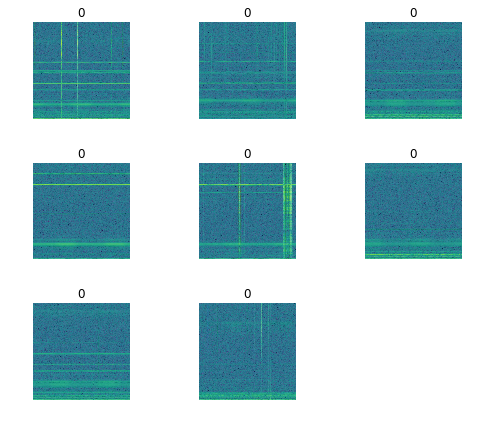

In [40]:
data.show_batch(rows=3, figsize=(7,6))

In [41]:
print(data.classes)
len(data.classes),data.c

[0, 1]


(2, 2)

In [42]:
gc.collect()
torch.cuda.empty_cache()

In [43]:
gpu_mem_get_free_no_cache()

10601

## Densenet

Try Densenet169 


In [44]:
from torchvision.models import densenet121
#valid loss jumps to 2 on 3rd epoch with dn169
#from torchvision.models import densenet169

In [45]:
data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, size=image_size, bs=24, suffix='.jpg')

In [46]:
learn = create_cnn(data, densenet121, metrics=[error_rate])

In [47]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1,2])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


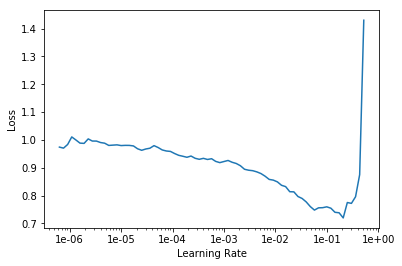

In [48]:
learn.lr_find()
learn.recorder.plot()

<pre>
densenet121
bs 16
learn.fit_one_cycle(cyc_len=5, max_lr=slice(1e-3))

epoch 	train_loss 	valid_loss 	error_rate 	time
1 	0.297709 	0.260330 	0.080070 	21:22
2 	0.234461 	0.248507 	0.077144 	21:17
3 	0.259230 	0.243873 	0.074393 	21:18
4 	0.218523 	1.336781 	0.088616 	21:25
5 	0.213893 	4.233240 	0.088265 	21:23
</pre>

In [50]:
learn.fit_one_cycle(cyc_len=3, max_lr=slice(2e-3))

epoch,train_loss,valid_loss,error_rate,time
1,0.273537,0.258927,0.077436,17:52
2,0.238978,0.225377,0.068130,17:44
3,0.202064,0.208822,0.066433,17:45


In [51]:
learn.save(f'{MODEL_NAME}_{UID}_aug_stage-1_dn121_{DATE}')

In [50]:
learn.load(f'600_ts_aug_dn_gtx_24907269_aug_stage-1_dn121_20190306')

Learner(data=ImageDataBunch;

Train: LabelList (68343 items)
x: ImageList
Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600)
y: CategoryList
0,0,1,1,1
Path: ../ssd_input/train_600_ts_aug_viridis-70-20;

Valid: LabelList (17085 items)
x: ImageList
Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600)
y: CategoryList
0,0,0,0,0
Path: ../ssd_input/train_600_ts_aug_viridis-70-20;

Test: None, model=DataParallel(
  (module): Sequential(
    (0): Sequential(
      (0): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, e

In [55]:
learn.fit_one_cycle(cyc_len=1, max_lr=slice(2e-3))

epoch,train_loss,valid_loss,error_rate,time
1,0.211049,0.223346,0.067603,17:44


In [ ]:
learn.save(f'{MODEL_NAME}_{UID}_aug_stage-1_dn121_{DATE}')

In [53]:
learn.fit_one_cycle(cyc_len=1, max_lr=slice(2e-3))

epoch,train_loss,valid_loss,error_rate,time
1,0.182040,1.787707,0.074100,17:43


In [ ]:
learn.fit_one_cycle(cyc_len=5, max_lr=slice(1e-3))

In [ ]:
learn.save(f'{MODEL_NAME}_{UID}_aug_stage-1-1_dn121_{DATE}')

In [ ]:
learn.fit_one_cycle(cyc_len=5, max_lr=slice(1e-3))

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.load(f'{MODEL_NAME}_{UID}_aug_stage-1_dn121_{DATE}')

### unfreeze

In [57]:
learn.unfreeze()


In [58]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


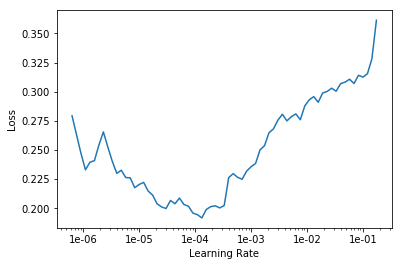

In [59]:
learn.recorder.plot()

In [60]:
learn.fit_one_cycle(3, max_lr=slice(1e-5))

epoch,train_loss,valid_loss,error_rate,time
1,0.204248,0.980329,0.080480,22:09
2,0.197052,0.336814,0.076149,22:12
3,0.203429,0.201473,0.066608,22:16


In [61]:
learn.save(f'{MODEL_NAME}_{UID}_aug_stage-2_dn121_{DATE}')

In [62]:
interp = ClassificationInterpretation.from_learner(learn)

In [63]:
interp.most_confused(min_val=2)

[(1, 0, 1001), (0, 1, 137)]

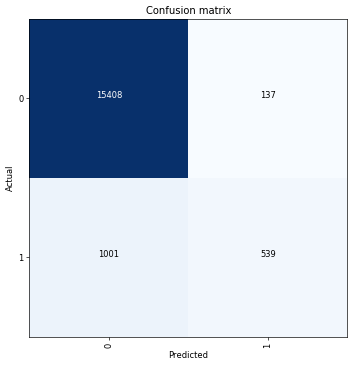

In [64]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

### Predict

In [51]:
test_images = glob.glob(str(test_path)+"/*.jpg")

In [47]:
#learn.load(f'{MODEL_NAME}_aug_stage-2_dn121_{DATE}')
learn.load(f'{MODEL_NAME}_aug_stage-1_rn50_{DATE}')

Learner(data=ImageDataBunch;

Train: LabelList (68343 items)
x: ImageList
Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600)
y: CategoryList
0,0,1,1,1
Path: ../ssd_input/train_600_ts_aug_viridis-70-20;

Valid: LabelList (17085 items)
x: ImageList
Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600),Image (3, 600, 600)
y: CategoryList
0,0,0,0,0
Path: ../ssd_input/train_600_ts_aug_viridis-70-20;

Test: None, model=DataParallel(
  (module): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(6

In [52]:
d={}
for i,fname in enumerate(test_images):
    im_name=fname.split('/')[3]
    signal_id = im_name[:im_name.index(".")]
    img = open_image(test_images[i])
    cat, val, probs=learn.predict(img)
    d[signal_id]=cat.__str__()
    #print(f'signal_id: {signal_id}, cat: {cat.__str__()}, val: {val}')

In [53]:
df_sub_dn121_u=pd.DataFrame.from_dict(d, orient='index')

In [54]:
df_sub_dn121_u=df_sub_dn121_u.reset_index()


In [55]:
df_sub_dn121_u.rename(columns={'index': 'signal_id', 0: 'target'}, inplace=True)
df_sub_dn121_u.head()

,signal_id,target
0,9267,0
1,12535,1
2,27325,0
3,10223,0
4,12016,0


In [56]:
df_sub_dn121_u.to_csv(path/f'submissions/submission_{MODEL_NAME}_aug_stage-1_rn50_20190306_24907269.csv', index=False)

In [ ]:
#submission 11 0.476
#near second best of 0.55
